<a href="https://colab.research.google.com/github/mahalasanayak/PlantDisease/blob/main/html_dense1212.0_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import numpy as np
import pandas as pd
import cv2 as cv 
import matplotlib.pyplot as plt
import os
import pickle
from collections import defaultdict

In [10]:
from keras.applications.densenet import DenseNet121
from keras.applications.densenet import preprocess_input
from keras.optimizers import Adam, SGD
from keras.models import Model, load_model
from keras.layers import *
from sklearn.model_selection import train_test_split
from keras.callbacks import *

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [12]:
disease_types = ['Pepper__bell___Bacterial_spot','Pepper__bell___healthy','Potato___Early_blight','rice_leafsmut','Potato___healthy','Tomato_Bacterial_spot','Tomato_Early_blight','Tomato_Late_blight','rice_brown_spot','Tomato_Septoria_leaf_spot','Tomato_Spider_mites_Two_spotted_spider_mite','Tomato__Target_Spot','Tomato__Tomato_YellowLeaf__Curl_Virus','rice_leaf_blight','Tomato_healthy']
data_dir = '/content/drive/MyDrive/archive/PlantVillage'
train_dir = os.path.join(data_dir)

In [13]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.tail()

File  ...    Disease Type
18473  Tomato_healthy/59e72cea-137e-4c76-ba58-8b60aab...  ...  Tomato_healthy
18474  Tomato_healthy/583238e5-392b-40ef-9bbe-be54bda...  ...  Tomato_healthy
18475  Tomato_healthy/5b2457f5-96d5-4bcd-8025-dc55e66...  ...  Tomato_healthy
18476  Tomato_healthy/5dbc2db5-5bb2-4a3c-9a90-d2228c1...  ...  Tomato_healthy
18477  Tomato_healthy/5d11d60f-fb4a-4178-9594-d017a0f...  ...  Tomato_healthy

[5 rows x 3 columns]

In [14]:
# Randomize the order of training set
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

File  ...               Disease Type
0  Tomato__Target_Spot/74aecabd-84ee-44f2-8a1f-69...  ...        Tomato__Target_Spot
1  Tomato__Target_Spot/95557bdf-e933-4181-a2b2-5f...  ...        Tomato__Target_Spot
2  Tomato_Septoria_leaf_spot/1c721799-1ac2-47dd-8...  ...  Tomato_Septoria_leaf_spot
3  Tomato_healthy/d4091850-464c-4655-9edc-395f43c...  ...             Tomato_healthy
4  Pepper__bell___healthy/ab4b562f-c5f1-4c24-826e...  ...     Pepper__bell___healthy

[5 rows x 3 columns]

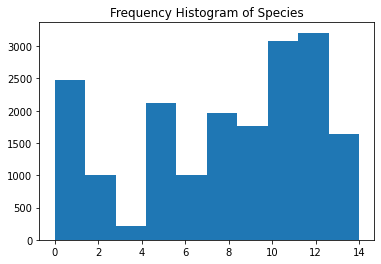

<Figure size 864x864 with 0 Axes>

In [15]:
# Plot a histogram
plt.hist(train['DiseaseID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

In [16]:
IMAGE_SIZE = 64

def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [17]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

18478it [1:45:44,  2.91it/s]


Train Shape: (18478, 64, 64, 3)


In [18]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=15)

In [19]:
BATCH_SIZE = 64

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

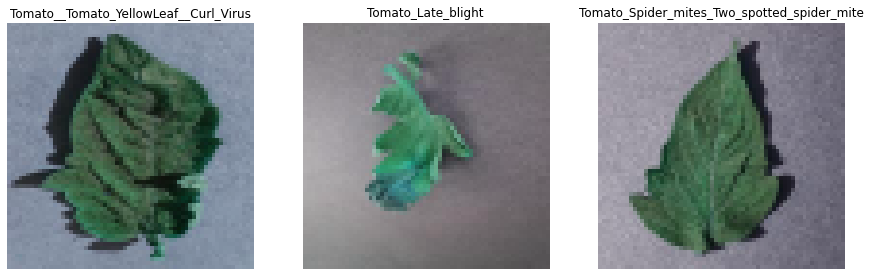

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

In [21]:
EPOCHS = 40
SIZE=64
N_ch=3

In [22]:
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(15,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [23]:
model = build_densenet()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)
# Fits the model on batches with real-time data augmentation
hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

29097984/29084464 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 3)         84        
_________________________________________________________________
densenet121 (Functional)     (None, None, None, 1024)  7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               262400

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
230/230 - 113s - loss: 2.5691 - accuracy: 0.3254 - val_loss: 1.3661 - val_accuracy: 0.6150

Epoch 00001: val_loss improved from inf to 1.36613, saving model to model.h5
Epoch 2/40
230/230 - 27s - loss: 1.1211 - accuracy: 0.6604 - val_loss: 0.6920 - val_accuracy: 0.7627

Epoch 00002: val_loss improved from 1.36613 to 0.69200, saving model to model.h5
Epoch 3/40
230/230 - 28s - loss: 0.7558 - accuracy: 0.7622 - val_loss: 0.8326 - val_accuracy: 0.7376

Epoch 00003: val_loss did not improve from 0.69200
Epoch 4/40
230/230 - 28s - loss: 0.5637 - accuracy: 0.8219 - val_loss: 0.3868 - val_accuracy: 0.8777

Epoch 00004: val_loss improved from 0.69200 to 0.38677, saving model to model.h5
Epoch 5/40
230/230 - 28s - loss: 0.4357 - accuracy: 0.8615 - val_loss: 0.4910 - val_accuracy: 0.8485

Epoch 00005: val_loss did not improve from 0.38677
Epoch 6/40
230/230 - 28s - loss: 0.3333 - accuracy: 0.8927 - val_loss: 0.6300 - val_accuracy: 0.8174

Epoch 00006: val_loss did not improve from 0.3

In [24]:
#model = load_model('../output/kaggle/working/model.h5')
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

116/116 [==============================] - 2s 18ms/step - loss: 0.3319 - accuracy: 0.9240
Final Loss: 0.3319302499294281, Final Accuracy: 0.9239718317985535


Text(0.5, 144.41374999999996, 'Predicted')

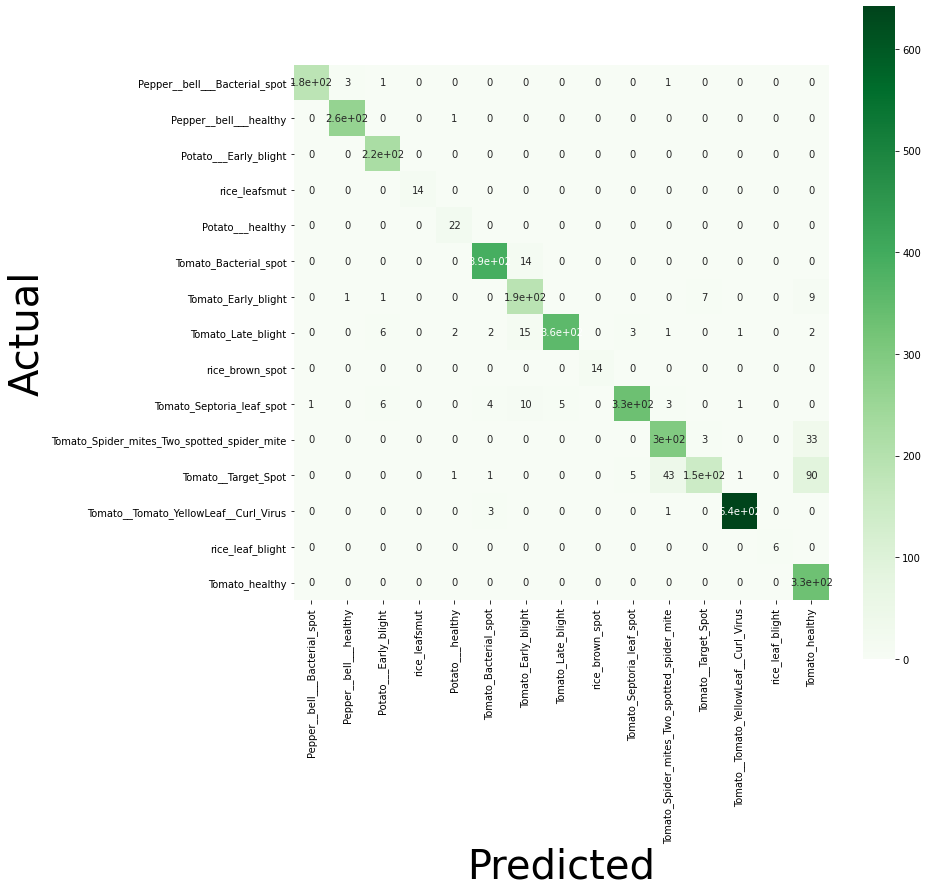

In [25]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

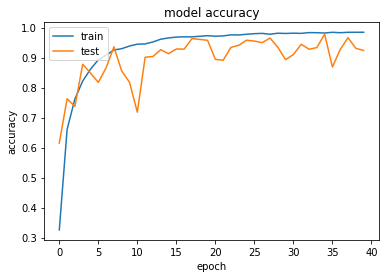

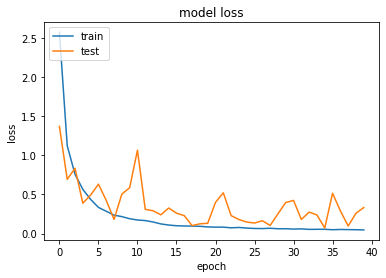

In [26]:
# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [27]:
!pip install flask_ngrok

In [38]:
from flask import *
from flask_ngrok import run_with_ngrok
from skimage import io
from keras.preprocessing import image

In [39]:
app=Flask(__name__)

In [40]:
def classify_image(filename):
  img = image.load_img(filename, grayscale=False, target_size=(64, 64))
  print(filename)
  show_img=image.load_img(filename, grayscale=False, target_size=(200, 200))
  disease_class = ['Pepper__bell___Bacterial_spot','Pepper__bell___healthy','Potato___Early_blight','rice_leafsmut','Potato___healthy','Tomato_Bacterial_spot','Tomato_Early_blight','Tomato_Late_blight','rice_brown_spot','Tomato_Septoria_leaf_spot','Tomato_Spider_mites_Two_spotted_spider_mite','Tomato__Target_Spot','Tomato__Tomato_YellowLeaf__Curl_Virus','rice_leaf_blight','Tomato_healthy']
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis = 0)
  #x = np.array(x, 'float32')
  x /= 255

  custom = model.predict(x)
  print(custom[0])



    #x = x.reshape([64, 64]);

    #plt.gray()
  plt.imshow(show_img)
  plt.show()

  a=custom[0]
  ind=np.argmax(a)
        
  print('Prediction:',disease_class[ind])
  return('Prediction:',disease_class[ind])






In [41]:
@app.route('/')
def home():
  return render_template('index.html')


@app.route('/result.html',methods=['POST','GET'])
def classify():
  if request.method =='POST':
    filen=request.files['img']
    filen.save(os.path.join("static",filen.filename))
    result1, result2 =classify_image(os.path.join("static",filen.filename))
    return render_template('result.html',name1=result1,name2=result2, name3=filen.filename)


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://e1349315acf0.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [26/Jun/2021 16:45:10] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 16:45:11] "GET /static/leaves.jpg HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 16:45:11] "GET /static/css/style.css HTTP/1.1" 404 -
127.0.0.1 - - [26/Jun/2021 16:45:11] "GET /static/css/icon.png HTTP/1.1" 404 -
127.0.0.1 - - [26/Jun/2021 16:45:12] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 16:45:13] "GET /static/css/style.css HTTP/1.1" 404 -
127.0.0.1 - - [26/Jun/2021 16:45:13] "GET /static/leaves.jpg HTTP/1.1" 200 -


static/blight-_0_2659.jpg
[1.0569129e-05 6.3183784e-02 3.9174856e-04 3.7049156e-02 7.6809185e-05
 1.4373040e-05 1.7043856e-03 9.2093274e-02 3.8062745e-01 3.4587416e-03
 3.5136742e-07 3.7254151e-06 1.2256148e-05 2.0364206e-02 4.0100917e-01]


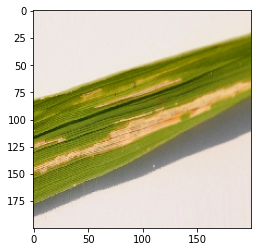

127.0.0.1 - - [26/Jun/2021 16:45:46] "POST /result.html HTTP/1.1" 200 -


Prediction: Tomato_healthy


127.0.0.1 - - [26/Jun/2021 16:45:47] "GET /static/blight-_0_2659.jpg HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 16:45:47] "GET /static/css/style.css HTTP/1.1" 404 -
127.0.0.1 - - [26/Jun/2021 16:45:48] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [26/Jun/2021 16:46:15] "GET /?submit= HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 16:46:15] "GET /static/css/style.css HTTP/1.1" 404 -


static/blight-_0_432.jpg
[3.2319012e-04 5.8021694e-01 3.0294136e-04 1.3709263e-03 1.0061473e-04
 1.1827712e-04 1.3327109e-02 3.8912657e-01 1.8764897e-03 7.8283474e-03
 1.3619243e-05 2.6627626e-05 5.0767128e-05 1.1386051e-03 4.1789305e-03]


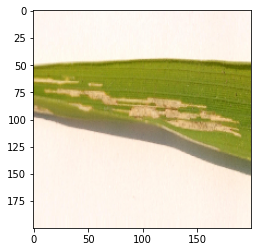

127.0.0.1 - - [26/Jun/2021 16:47:29] "POST /result.html HTTP/1.1" 200 -


Prediction: Pepper__bell___healthy


127.0.0.1 - - [26/Jun/2021 16:47:29] "GET /static/blight-_0_432.jpg HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 16:47:29] "GET /static/css/style.css HTTP/1.1" 404 -
127.0.0.1 - - [26/Jun/2021 16:47:34] "GET /?submit= HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 16:47:34] "GET /static/css/style.css HTTP/1.1" 404 -


static/DSC_0106.jpg
[2.8681427e-05 2.9987674e-02 2.1737620e-02 1.7371919e-03 3.5036013e-03
 7.7607720e-06 1.7085542e-04 4.3475075e-04 1.9440388e-02 9.1164786e-01
 2.5908481e-08 2.5898776e-06 3.7057245e-05 6.4972060e-04 1.0614337e-02]


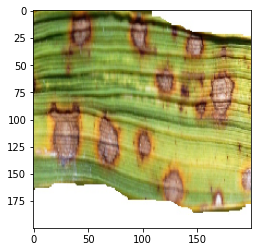

127.0.0.1 - - [26/Jun/2021 16:47:47] "POST /result.html HTTP/1.1" 200 -


Prediction: Tomato_Septoria_leaf_spot


127.0.0.1 - - [26/Jun/2021 16:47:47] "GET /static/css/style.css HTTP/1.1" 404 -
127.0.0.1 - - [26/Jun/2021 16:47:47] "GET /static/DSC_0106.jpg HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 16:47:55] "GET /?submit= HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 16:47:55] "GET /static/css/style.css HTTP/1.1" 404 -


static/0a0dbf1f-1131-496f-b337-169ec6693e6f___NREC_B.Spot 9241.JPG
[9.3249946e-05 5.9658515e-01 8.1206433e-02 2.2158828e-03 3.8897637e-02
 3.1837078e-07 5.5398914e-07 3.6610098e-05 1.7294232e-02 2.7768970e-03
 1.8022757e-07 2.2946766e-05 6.5012392e-07 3.2167626e-04 2.6054761e-01]


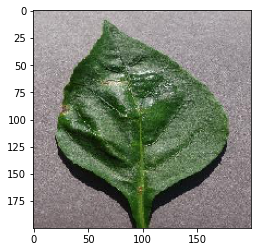

127.0.0.1 - - [26/Jun/2021 16:53:16] "POST /result.html HTTP/1.1" 200 -


Prediction: Pepper__bell___healthy


127.0.0.1 - - [26/Jun/2021 16:53:16] "GET /static/0a0dbf1f-1131-496f-b337-169ec6693e6f___NREC_B.Spot%209241.JPG HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 16:53:16] "GET /static/css/style.css HTTP/1.1" 404 -
127.0.0.1 - - [26/Jun/2021 16:53:22] "GET /?submit= HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 16:53:22] "GET /static/css/style.css HTTP/1.1" 404 -
127.0.0.1 - - [26/Jun/2021 16:53:24] "GET /?submit= HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 16:53:25] "GET /static/leaves.jpg HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 16:53:25] "GET /static/css/style.css HTTP/1.1" 404 -


static/DSC_0309.JPG
[5.1773514e-04 5.6208495e-02 2.8065369e-02 1.3773821e-01 1.4099852e-03
 3.3056473e-05 4.4289534e-03 1.3669958e-02 5.5107839e-02 6.4086848e-01
 1.6216738e-05 1.0197513e-04 1.9308425e-05 4.2635119e-03 5.7550859e-02]


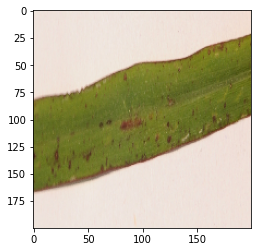

127.0.0.1 - - [26/Jun/2021 16:53:34] "POST /result.html HTTP/1.1" 200 -


Prediction: Tomato_Septoria_leaf_spot


127.0.0.1 - - [26/Jun/2021 16:53:34] "GET /static/css/style.css HTTP/1.1" 404 -
127.0.0.1 - - [26/Jun/2021 16:53:35] "GET /static/DSC_0309.JPG HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 16:53:38] "GET /?submit= HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 16:53:39] "GET /static/css/style.css HTTP/1.1" 404 -


static/blight-_0_2019.jpg
[6.1598519e-05 5.8777582e-02 1.1333922e-03 4.5560785e-02 1.2289868e-04
 6.2130734e-05 2.3807861e-02 1.5131401e-01 3.8425222e-01 1.4858296e-02
 4.9812284e-06 4.5413140e-05 4.2836964e-05 2.1556338e-02 2.9839969e-01]


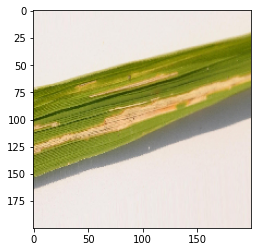

127.0.0.1 - - [26/Jun/2021 16:53:57] "POST /result.html HTTP/1.1" 200 -


Prediction: rice_brown_spot


127.0.0.1 - - [26/Jun/2021 16:53:57] "GET /static/css/style.css HTTP/1.1" 404 -
127.0.0.1 - - [26/Jun/2021 16:53:58] "GET /static/blight-_0_2019.jpg HTTP/1.1" 200 -


static/blight-_0_2019.jpg
[6.1598519e-05 5.8777582e-02 1.1333922e-03 4.5560785e-02 1.2289868e-04
 6.2130734e-05 2.3807861e-02 1.5131401e-01 3.8425222e-01 1.4858296e-02
 4.9812284e-06 4.5413140e-05 4.2836964e-05 2.1556338e-02 2.9839969e-01]


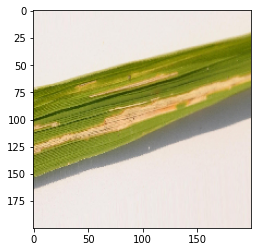

127.0.0.1 - - [26/Jun/2021 16:54:44] "POST /result.html HTTP/1.1" 200 -


Prediction: rice_brown_spot


127.0.0.1 - - [26/Jun/2021 16:54:45] "GET /static/css/style.css HTTP/1.1" 404 -
127.0.0.1 - - [26/Jun/2021 16:54:49] "GET /?submit= HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 16:54:49] "GET /static/css/style.css HTTP/1.1" 404 -


static/blight-_0_2019.jpg
[6.1598519e-05 5.8777582e-02 1.1333922e-03 4.5560785e-02 1.2289868e-04
 6.2130734e-05 2.3807861e-02 1.5131401e-01 3.8425222e-01 1.4858296e-02
 4.9812284e-06 4.5413140e-05 4.2836964e-05 2.1556338e-02 2.9839969e-01]


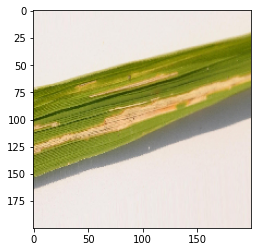

127.0.0.1 - - [26/Jun/2021 16:54:57] "POST /result.html HTTP/1.1" 200 -


Prediction: rice_brown_spot


127.0.0.1 - - [26/Jun/2021 16:54:58] "GET /static/css/style.css HTTP/1.1" 404 -
127.0.0.1 - - [26/Jun/2021 16:55:02] "GET /static/css/style.css HTTP/1.1" 404 -


static/blight-_0_2019.jpg
[6.1598519e-05 5.8777582e-02 1.1333922e-03 4.5560785e-02 1.2289868e-04
 6.2130734e-05 2.3807861e-02 1.5131401e-01 3.8425222e-01 1.4858296e-02
 4.9812284e-06 4.5413140e-05 4.2836964e-05 2.1556338e-02 2.9839969e-01]


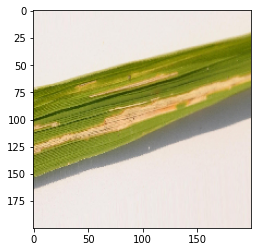

127.0.0.1 - - [26/Jun/2021 16:55:05] "POST /result.html HTTP/1.1" 200 -


Prediction: rice_brown_spot


127.0.0.1 - - [26/Jun/2021 16:55:05] "GET /static/css/style.css HTTP/1.1" 404 -


static/blight-_0_2019.jpg
[6.1598519e-05 5.8777582e-02 1.1333922e-03 4.5560785e-02 1.2289868e-04
 6.2130734e-05 2.3807861e-02 1.5131401e-01 3.8425222e-01 1.4858296e-02
 4.9812284e-06 4.5413140e-05 4.2836964e-05 2.1556338e-02 2.9839969e-01]


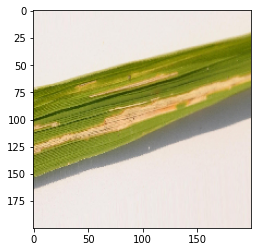

127.0.0.1 - - [26/Jun/2021 16:55:12] "POST /result.html HTTP/1.1" 200 -


Prediction: rice_brown_spot


127.0.0.1 - - [26/Jun/2021 16:55:12] "GET /static/css/style.css HTTP/1.1" 404 -
127.0.0.1 - - [26/Jun/2021 16:55:17] "GET /?submit= HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 16:55:18] "GET /static/css/style.css HTTP/1.1" 404 -


static/blight-_0_432 (1).jpg
[3.2319012e-04 5.8021694e-01 3.0294136e-04 1.3709263e-03 1.0061473e-04
 1.1827712e-04 1.3327109e-02 3.8912657e-01 1.8764897e-03 7.8283474e-03
 1.3619243e-05 2.6627626e-05 5.0767128e-05 1.1386051e-03 4.1789305e-03]


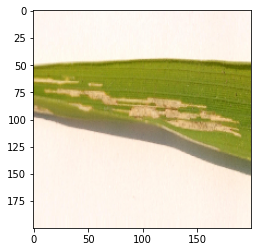

127.0.0.1 - - [26/Jun/2021 16:55:30] "POST /result.html HTTP/1.1" 200 -


Prediction: Pepper__bell___healthy


127.0.0.1 - - [26/Jun/2021 16:55:30] "GET /static/blight-_0_432%20%281%29.jpg HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 16:55:30] "GET /static/css/style.css HTTP/1.1" 404 -
127.0.0.1 - - [26/Jun/2021 16:55:33] "GET /?submit= HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 16:55:34] "GET /static/css/style.css HTTP/1.1" 404 -


static/blight-_0_546.jpg
[1.52096894e-04 8.83799195e-02 8.52155674e-04 1.27905048e-02
 1.21372126e-04 1.86321558e-04 9.01787207e-02 1.09163329e-01
 1.87786669e-02 6.45370245e-01 8.27007898e-06 1.07646920e-04
 3.93820665e-04 7.89980218e-03 2.56169830e-02]


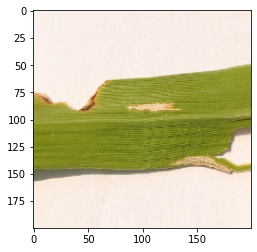

127.0.0.1 - - [26/Jun/2021 16:55:43] "POST /result.html HTTP/1.1" 200 -


Prediction: Tomato_Septoria_leaf_spot


127.0.0.1 - - [26/Jun/2021 16:55:44] "GET /static/blight-_0_546.jpg HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 16:55:44] "GET /static/css/style.css HTTP/1.1" 404 -
127.0.0.1 - - [26/Jun/2021 16:55:47] "GET /?submit= HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 16:55:47] "GET /static/css/style.css HTTP/1.1" 404 -


static/blight-_0_1905.jpg
[7.5491604e-05 5.2090801e-02 1.1586213e-03 6.2263393e-01 2.9456391e-04
 9.0870053e-06 2.7127546e-04 3.8042555e-03 1.9261536e-01 3.7396736e-02
 4.2298416e-06 3.0134459e-05 9.5860087e-06 7.2788903e-03 8.2326993e-02]


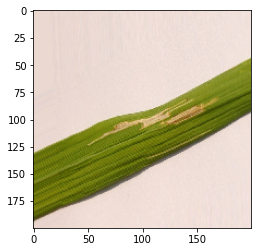

127.0.0.1 - - [26/Jun/2021 16:55:55] "POST /result.html HTTP/1.1" 200 -


Prediction: rice_leafsmut


127.0.0.1 - - [26/Jun/2021 16:55:56] "GET /static/css/style.css HTTP/1.1" 404 -
127.0.0.1 - - [26/Jun/2021 16:55:56] "GET /static/blight-_0_1905.jpg HTTP/1.1" 200 -


static/blight-_0_1905.jpg
[7.5491604e-05 5.2090801e-02 1.1586213e-03 6.2263393e-01 2.9456391e-04
 9.0870053e-06 2.7127546e-04 3.8042555e-03 1.9261536e-01 3.7396736e-02
 4.2298416e-06 3.0134459e-05 9.5860087e-06 7.2788903e-03 8.2326993e-02]


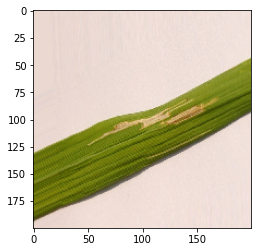

127.0.0.1 - - [26/Jun/2021 16:56:10] "POST /result.html HTTP/1.1" 200 -


Prediction: rice_leafsmut


127.0.0.1 - - [26/Jun/2021 16:56:10] "GET /static/css/style.css HTTP/1.1" 404 -


static/blight-_0_1905.jpg
[7.5491604e-05 5.2090801e-02 1.1586213e-03 6.2263393e-01 2.9456391e-04
 9.0870053e-06 2.7127546e-04 3.8042555e-03 1.9261536e-01 3.7396736e-02
 4.2298416e-06 3.0134459e-05 9.5860087e-06 7.2788903e-03 8.2326993e-02]


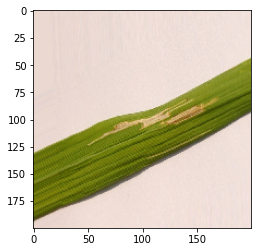

127.0.0.1 - - [26/Jun/2021 16:56:15] "POST /result.html HTTP/1.1" 200 -


Prediction: rice_leafsmut


127.0.0.1 - - [26/Jun/2021 16:56:16] "GET /static/css/style.css HTTP/1.1" 404 -


static/blight-_0_1905.jpg
[7.5491604e-05 5.2090801e-02 1.1586213e-03 6.2263393e-01 2.9456391e-04
 9.0870053e-06 2.7127546e-04 3.8042555e-03 1.9261536e-01 3.7396736e-02
 4.2298416e-06 3.0134459e-05 9.5860087e-06 7.2788903e-03 8.2326993e-02]


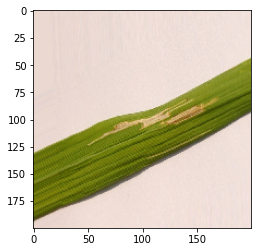

127.0.0.1 - - [26/Jun/2021 16:56:21] "POST /result.html HTTP/1.1" 200 -


Prediction: rice_leafsmut


127.0.0.1 - - [26/Jun/2021 16:56:21] "GET /static/css/style.css HTTP/1.1" 404 -
127.0.0.1 - - [26/Jun/2021 16:56:27] "GET /?submit= HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 16:56:28] "GET /static/css/style.css HTTP/1.1" 404 -


static/spot-_0_74.jpg
[7.6972092e-06 1.5231612e-01 1.4779734e-03 6.9667408e-03 9.0163230e-05
 2.6386108e-06 1.1268546e-03 4.5658224e-03 7.6988512e-01 3.3407712e-03
 3.7730338e-08 1.1940336e-06 8.8663671e-07 1.3904622e-02 4.6313349e-02]


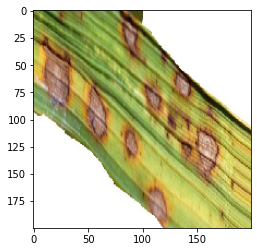

127.0.0.1 - - [26/Jun/2021 16:56:42] "POST /result.html HTTP/1.1" 200 -


Prediction: rice_brown_spot


127.0.0.1 - - [26/Jun/2021 16:56:42] "GET /static/css/style.css HTTP/1.1" 404 -
127.0.0.1 - - [26/Jun/2021 16:56:42] "GET /static/spot-_0_74.jpg HTTP/1.1" 200 -


static/spot-_0_74.jpg
[7.6972092e-06 1.5231612e-01 1.4779734e-03 6.9667408e-03 9.0163230e-05
 2.6386108e-06 1.1268546e-03 4.5658224e-03 7.6988512e-01 3.3407712e-03
 3.7730338e-08 1.1940336e-06 8.8663671e-07 1.3904622e-02 4.6313349e-02]


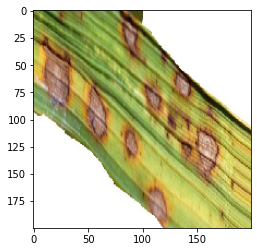

127.0.0.1 - - [26/Jun/2021 16:56:54] "POST /result.html HTTP/1.1" 200 -


Prediction: rice_brown_spot


127.0.0.1 - - [26/Jun/2021 16:56:54] "GET /static/css/style.css HTTP/1.1" 404 -
127.0.0.1 - - [26/Jun/2021 16:56:56] "GET /?submit= HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 16:56:57] "GET /static/css/style.css HTTP/1.1" 404 -


static/spot-_0_93.jpg
[4.4519067e-05 4.4150665e-02 2.2182849e-03 2.4062960e-01 5.2297785e-04
 7.3023789e-06 2.4669846e-03 2.2082560e-02 4.7979802e-01 1.9390430e-02
 1.1575019e-06 5.4241527e-06 1.3335852e-05 3.7417663e-03 1.8492694e-01]


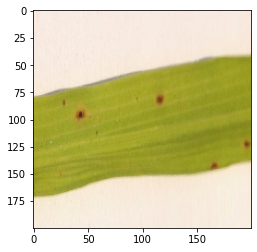

127.0.0.1 - - [26/Jun/2021 16:57:05] "POST /result.html HTTP/1.1" 200 -


Prediction: rice_brown_spot


127.0.0.1 - - [26/Jun/2021 16:57:05] "GET /static/spot-_0_93.jpg HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 16:57:05] "GET /static/css/style.css HTTP/1.1" 404 -
127.0.0.1 - - [26/Jun/2021 16:57:59] "GET /?submit= HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 16:58:00] "GET /static/css/style.css HTTP/1.1" 404 -


static/DSC_0302.JPG
[2.0029240e-04 1.0772084e-01 1.1676397e-03 8.8566504e-03 7.7078046e-05
 4.3186304e-04 6.4950812e-01 1.3543835e-01 7.4957535e-03 8.1974745e-02
 5.2862273e-05 1.0769648e-04 1.4985152e-04 1.6899020e-03 5.1283785e-03]


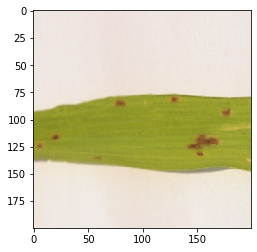

127.0.0.1 - - [26/Jun/2021 16:58:13] "POST /result.html HTTP/1.1" 200 -


Prediction: Tomato_Early_blight


127.0.0.1 - - [26/Jun/2021 16:58:13] "GET /static/DSC_0302.JPG HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 16:58:14] "GET /static/css/style.css HTTP/1.1" 404 -
127.0.0.1 - - [26/Jun/2021 16:58:17] "GET /?submit= HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 16:58:17] "GET /static/css/style.css HTTP/1.1" 404 -


static/DSC_0300.JPG
[4.2020448e-04 1.2908119e-01 4.0069548e-03 2.1257859e-01 1.8277230e-03
 7.7105957e-05 4.9260496e-03 9.0069305e-03 2.6356848e-02 5.3885037e-01
 2.4380830e-05 7.8703561e-05 4.8697970e-05 1.3574662e-03 7.1358800e-02]


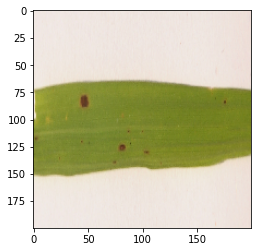

127.0.0.1 - - [26/Jun/2021 16:58:27] "POST /result.html HTTP/1.1" 200 -


Prediction: Tomato_Septoria_leaf_spot


127.0.0.1 - - [26/Jun/2021 16:58:27] "GET /static/css/style.css HTTP/1.1" 404 -
127.0.0.1 - - [26/Jun/2021 16:58:27] "GET /static/DSC_0300.JPG HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 16:58:31] "GET /?submit= HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 16:58:31] "GET /static/css/style.css HTTP/1.1" 404 -


static/spot-_0_74.jpg
[7.6972092e-06 1.5231612e-01 1.4779734e-03 6.9667408e-03 9.0163230e-05
 2.6386108e-06 1.1268546e-03 4.5658224e-03 7.6988512e-01 3.3407712e-03
 3.7730338e-08 1.1940336e-06 8.8663671e-07 1.3904622e-02 4.6313349e-02]


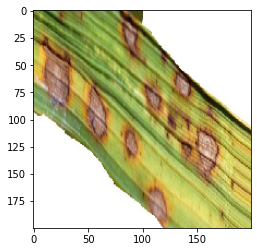

127.0.0.1 - - [26/Jun/2021 16:58:47] "POST /result.html HTTP/1.1" 200 -


Prediction: rice_brown_spot


127.0.0.1 - - [26/Jun/2021 16:58:48] "GET /static/css/style.css HTTP/1.1" 404 -
127.0.0.1 - - [26/Jun/2021 16:58:54] "GET /?submit= HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 16:58:54] "GET /static/css/style.css HTTP/1.1" 404 -


static/blight-_0_432 (1).jpg
[3.2319012e-04 5.8021694e-01 3.0294136e-04 1.3709263e-03 1.0061473e-04
 1.1827712e-04 1.3327109e-02 3.8912657e-01 1.8764897e-03 7.8283474e-03
 1.3619243e-05 2.6627626e-05 5.0767128e-05 1.1386051e-03 4.1789305e-03]


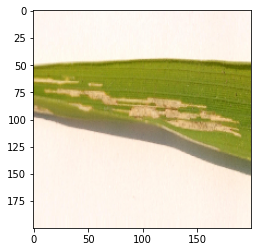

127.0.0.1 - - [26/Jun/2021 16:59:08] "POST /result.html HTTP/1.1" 200 -


Prediction: Pepper__bell___healthy


127.0.0.1 - - [26/Jun/2021 16:59:08] "GET /static/css/style.css HTTP/1.1" 404 -
127.0.0.1 - - [26/Jun/2021 16:59:11] "GET /?submit= HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 16:59:11] "GET /static/css/style.css HTTP/1.1" 404 -


static/blight-_0_546.jpg
[1.52096894e-04 8.83799195e-02 8.52155674e-04 1.27905048e-02
 1.21372126e-04 1.86321558e-04 9.01787207e-02 1.09163329e-01
 1.87786669e-02 6.45370245e-01 8.27007898e-06 1.07646920e-04
 3.93820665e-04 7.89980218e-03 2.56169830e-02]


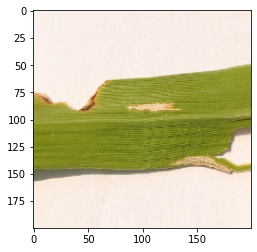

127.0.0.1 - - [26/Jun/2021 16:59:20] "POST /result.html HTTP/1.1" 200 -


Prediction: Tomato_Septoria_leaf_spot


127.0.0.1 - - [26/Jun/2021 16:59:20] "GET /static/css/style.css HTTP/1.1" 404 -
127.0.0.1 - - [26/Jun/2021 16:59:24] "GET /?submit= HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 16:59:24] "GET /static/css/style.css HTTP/1.1" 404 -


static/blight-_0_1602.jpg
[1.65409700e-03 2.63679862e-01 6.53936120e-04 4.81183119e-02
 1.57776478e-04 1.36534654e-04 1.14360191e-01 2.89090097e-01
 1.06656803e-02 2.38563940e-01 3.23899236e-04 2.73859419e-04
 1.18984906e-04 1.09364958e-02 2.12662872e-02]


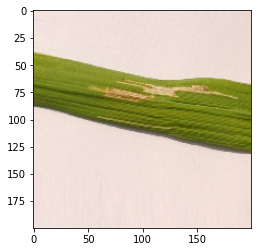

127.0.0.1 - - [26/Jun/2021 16:59:32] "POST /result.html HTTP/1.1" 200 -


Prediction: Tomato_Late_blight


127.0.0.1 - - [26/Jun/2021 16:59:32] "GET /static/blight-_0_1602.jpg HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 16:59:35] "GET /?submit= HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 16:59:36] "GET /static/css/style.css HTTP/1.1" 404 -


static/blight-_0_1905.jpg
[7.5491604e-05 5.2090801e-02 1.1586213e-03 6.2263393e-01 2.9456391e-04
 9.0870053e-06 2.7127546e-04 3.8042555e-03 1.9261536e-01 3.7396736e-02
 4.2298416e-06 3.0134459e-05 9.5860087e-06 7.2788903e-03 8.2326993e-02]


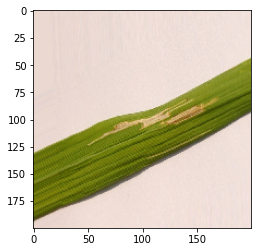

127.0.0.1 - - [26/Jun/2021 16:59:43] "POST /result.html HTTP/1.1" 200 -


Prediction: rice_leafsmut


127.0.0.1 - - [26/Jun/2021 16:59:43] "GET /static/css/style.css HTTP/1.1" 404 -
127.0.0.1 - - [26/Jun/2021 16:59:46] "GET /?submit= HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 16:59:47] "GET /static/css/style.css HTTP/1.1" 404 -


static/blight-_0_2019.jpg
[6.1598519e-05 5.8777582e-02 1.1333922e-03 4.5560785e-02 1.2289868e-04
 6.2130734e-05 2.3807861e-02 1.5131401e-01 3.8425222e-01 1.4858296e-02
 4.9812284e-06 4.5413140e-05 4.2836964e-05 2.1556338e-02 2.9839969e-01]


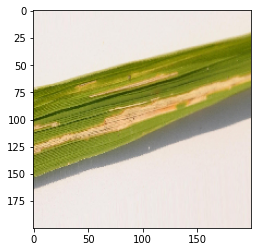

127.0.0.1 - - [26/Jun/2021 16:59:54] "POST /result.html HTTP/1.1" 200 -


Prediction: rice_brown_spot


127.0.0.1 - - [26/Jun/2021 16:59:54] "GET /static/css/style.css HTTP/1.1" 404 -
127.0.0.1 - - [26/Jun/2021 16:59:57] "GET /?submit= HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 16:59:58] "GET /static/css/style.css HTTP/1.1" 404 -


static/DSC_0309.JPG
[5.1773514e-04 5.6208495e-02 2.8065369e-02 1.3773821e-01 1.4099852e-03
 3.3056473e-05 4.4289534e-03 1.3669958e-02 5.5107839e-02 6.4086848e-01
 1.6216738e-05 1.0197513e-04 1.9308425e-05 4.2635119e-03 5.7550859e-02]


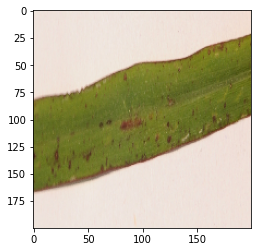

127.0.0.1 - - [26/Jun/2021 17:00:12] "POST /result.html HTTP/1.1" 200 -


Prediction: Tomato_Septoria_leaf_spot


127.0.0.1 - - [26/Jun/2021 17:00:13] "GET /static/css/style.css HTTP/1.1" 404 -
127.0.0.1 - - [26/Jun/2021 17:00:16] "GET /?submit= HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 17:00:16] "GET /static/css/style.css HTTP/1.1" 404 -


static/DSC_0507.jpg
[3.2605600e-04 8.6164987e-01 3.1405340e-03 1.1783919e-02 4.3379498e-04
 1.2639958e-04 2.2853080e-02 2.4030471e-02 3.5851173e-02 1.9461479e-02
 4.0191203e-06 4.8216589e-05 3.7335526e-04 1.1389793e-03 1.8778741e-02]


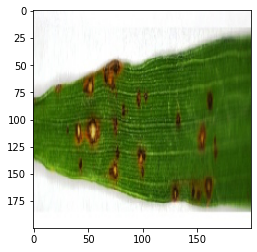

127.0.0.1 - - [26/Jun/2021 17:00:22] "POST /result.html HTTP/1.1" 200 -


Prediction: Pepper__bell___healthy


127.0.0.1 - - [26/Jun/2021 17:00:23] "GET /static/DSC_0507.jpg HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 17:00:23] "GET /static/css/style.css HTTP/1.1" 404 -
127.0.0.1 - - [26/Jun/2021 17:00:26] "GET /?submit= HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 17:00:27] "GET /static/css/style.css HTTP/1.1" 404 -


static/smut-_0_741.jpg
[1.8807543e-03 4.7481284e-02 5.2360860e-03 2.5359990e-02 3.9023257e-04
 8.7033305e-04 3.0769148e-01 6.3398473e-02 1.6089238e-02 5.2059776e-01
 2.0173025e-04 6.2126212e-04 7.8236881e-05 4.7118687e-03 5.3911959e-03]


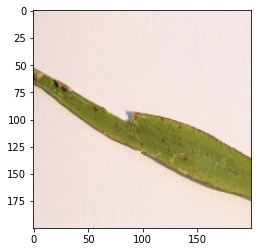

127.0.0.1 - - [26/Jun/2021 17:00:33] "POST /result.html HTTP/1.1" 200 -


Prediction: Tomato_Septoria_leaf_spot


127.0.0.1 - - [26/Jun/2021 17:00:34] "GET /static/smut-_0_741.jpg HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 17:00:34] "GET /static/css/style.css HTTP/1.1" 404 -
127.0.0.1 - - [26/Jun/2021 17:00:37] "GET /?submit= HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 17:00:37] "GET /static/css/style.css HTTP/1.1" 404 -


static/smut-_0_1226.jpg
[3.3610415e-06 6.7058136e-03 4.1884204e-04 5.2087277e-02 1.5611347e-04
 8.8590122e-07 3.1831340e-05 1.1171631e-02 9.2951030e-02 2.1172683e-01
 5.8641085e-08 2.5300633e-07 5.0911581e-06 3.0878955e-04 6.2443215e-01]


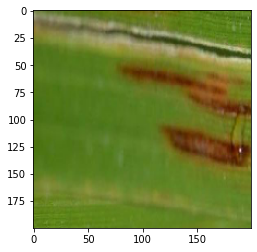

127.0.0.1 - - [26/Jun/2021 17:00:45] "POST /result.html HTTP/1.1" 200 -


Prediction: Tomato_healthy


127.0.0.1 - - [26/Jun/2021 17:00:45] "GET /static/smut-_0_1226.jpg HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 17:00:45] "GET /static/css/style.css HTTP/1.1" 404 -
127.0.0.1 - - [26/Jun/2021 17:00:48] "GET /?submit= HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 17:00:49] "GET /static/css/style.css HTTP/1.1" 404 -


static/smut-_0_1330.jpg
[1.6547147e-04 4.4033903e-01 3.0432877e-03 3.8551368e-02 3.0967998e-04
 5.7645084e-05 4.6437170e-02 5.3421655e-03 4.3925965e-01 3.3132541e-03
 3.7364828e-06 4.2439893e-05 3.4200744e-05 5.0621699e-03 1.8038701e-02]


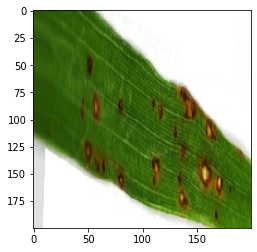

127.0.0.1 - - [26/Jun/2021 17:00:56] "POST /result.html HTTP/1.1" 200 -


Prediction: Pepper__bell___healthy


127.0.0.1 - - [26/Jun/2021 17:00:56] "GET /static/smut-_0_1330.jpg HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 17:00:56] "GET /static/css/style.css HTTP/1.1" 404 -
127.0.0.1 - - [26/Jun/2021 17:01:00] "GET /?submit= HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 17:01:01] "GET /static/css/style.css HTTP/1.1" 404 -


static/blight-_0_3325.jpg
[6.8489206e-04 3.2936800e-01 6.6235242e-04 2.4176842e-02 1.9421175e-04
 3.5223295e-04 1.3873553e-01 2.4523520e-01 2.0906342e-02 1.9261274e-01
 3.4303175e-05 9.0514492e-05 6.8706169e-04 4.0441500e-03 4.2215616e-02]


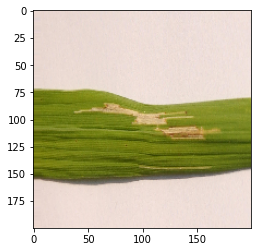

127.0.0.1 - - [26/Jun/2021 17:06:28] "POST /result.html HTTP/1.1" 200 -


Prediction: Pepper__bell___healthy


127.0.0.1 - - [26/Jun/2021 17:06:29] "GET /static/css/style.css HTTP/1.1" 404 -
127.0.0.1 - - [26/Jun/2021 17:06:29] "GET /static/blight-_0_3325.jpg HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 17:06:32] "GET /?submit= HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 17:06:32] "GET /static/css/style.css HTTP/1.1" 404 -


static/blight-_0_3103.jpg
[1.5083084e-05 2.8224650e-01 4.4719101e-04 9.6873194e-03 2.9140885e-05
 1.2310384e-05 6.7534358e-03 3.3018433e-02 5.3948814e-01 1.2633839e-04
 2.8497098e-07 2.0591774e-06 1.3087044e-06 7.0666134e-02 5.7506338e-02]


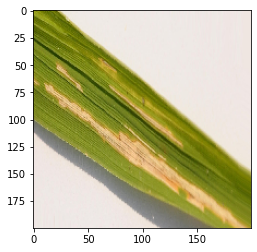

127.0.0.1 - - [26/Jun/2021 17:06:41] "POST /result.html HTTP/1.1" 200 -


Prediction: rice_brown_spot


127.0.0.1 - - [26/Jun/2021 17:06:42] "GET /static/blight-_0_3103.jpg HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 17:06:42] "GET /static/css/style.css HTTP/1.1" 404 -
127.0.0.1 - - [26/Jun/2021 17:06:45] "GET /?submit= HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 17:06:46] "GET /static/css/style.css HTTP/1.1" 404 -


static/blight-_0_2829.jpg
[2.8827391e-04 8.4301375e-02 1.0615735e-03 5.9571601e-03 9.8127646e-05
 2.3296736e-04 4.9063709e-01 1.1966392e-01 1.5903609e-02 2.6336136e-01
 8.6733580e-06 1.2548323e-04 2.3317775e-04 3.6496432e-03 1.4477536e-02]


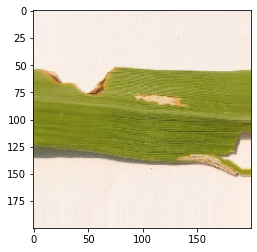

127.0.0.1 - - [26/Jun/2021 17:06:56] "POST /result.html HTTP/1.1" 200 -


Prediction: Tomato_Early_blight


127.0.0.1 - - [26/Jun/2021 17:06:56] "GET /static/css/style.css HTTP/1.1" 404 -
127.0.0.1 - - [26/Jun/2021 17:06:56] "GET /static/blight-_0_2829.jpg HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 17:06:59] "GET /?submit= HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 17:07:00] "GET /static/css/style.css HTTP/1.1" 404 -


static/blight-_0_2659 (1).jpg
[1.0569129e-05 6.3183784e-02 3.9174856e-04 3.7049156e-02 7.6809185e-05
 1.4373040e-05 1.7043856e-03 9.2093274e-02 3.8062745e-01 3.4587416e-03
 3.5136742e-07 3.7254151e-06 1.2256148e-05 2.0364206e-02 4.0100917e-01]


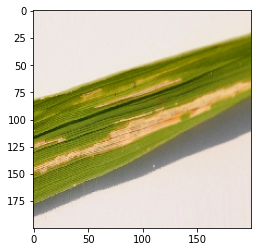

127.0.0.1 - - [26/Jun/2021 17:07:10] "POST /result.html HTTP/1.1" 200 -


Prediction: Tomato_healthy


127.0.0.1 - - [26/Jun/2021 17:07:11] "GET /static/css/style.css HTTP/1.1" 404 -
127.0.0.1 - - [26/Jun/2021 17:07:11] "GET /static/blight-_0_2659%20%281%29.jpg HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 17:08:04] "GET /?submit= HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 17:08:05] "GET /static/css/style.css HTTP/1.1" 404 -


static/blight-_0_2441.jpg
[1.5071639e-03 2.0258993e-01 7.0978038e-04 1.3048266e-01 1.7633509e-04
 1.3539693e-04 1.2680432e-01 5.2613519e-02 3.0296458e-02 3.6136526e-01
 2.9513409e-05 1.0266866e-04 3.2357694e-04 6.3455454e-03 8.6517878e-02]


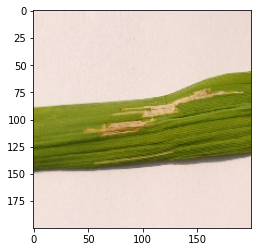

127.0.0.1 - - [26/Jun/2021 17:08:16] "POST /result.html HTTP/1.1" 200 -


Prediction: Tomato_Septoria_leaf_spot


127.0.0.1 - - [26/Jun/2021 17:08:16] "GET /static/blight-_0_2441.jpg HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 17:08:16] "GET /static/css/style.css HTTP/1.1" 404 -
127.0.0.1 - - [26/Jun/2021 17:08:19] "GET /?submit= HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 17:08:19] "GET /static/css/style.css HTTP/1.1" 404 -


static/DSC_0328.jpg
[4.7664612e-04 1.3136171e-02 3.2617585e-03 1.5433780e-03 1.0605494e-04
 1.2987941e-04 7.0375150e-01 5.0705478e-02 1.1617360e-03 2.2263519e-01
 1.4413020e-04 1.3107969e-04 4.3283821e-05 3.9751965e-04 2.3762747e-03]


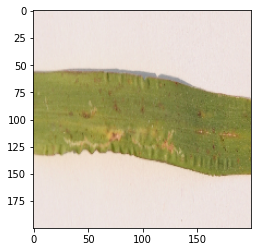

127.0.0.1 - - [26/Jun/2021 17:08:32] "POST /result.html HTTP/1.1" 200 -


Prediction: Tomato_Early_blight


127.0.0.1 - - [26/Jun/2021 17:08:33] "GET /static/DSC_0328.jpg HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 17:08:33] "GET /static/css/style.css HTTP/1.1" 404 -
127.0.0.1 - - [26/Jun/2021 17:08:36] "GET /?submit= HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 17:08:36] "GET /static/css/style.css HTTP/1.1" 404 -


static/smut-_0_2032.jpg
[2.9965190e-03 4.4356307e-01 1.3656603e-02 1.6626717e-01 1.3192385e-03
 5.4769476e-05 4.7065929e-02 6.7387059e-02 9.9820994e-02 8.2480751e-02
 8.2890605e-05 1.6186030e-04 3.8657938e-05 8.2661267e-03 6.6838294e-02]


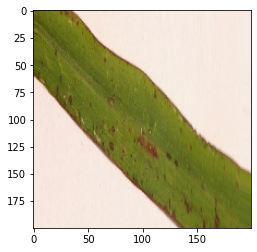

127.0.0.1 - - [26/Jun/2021 17:08:47] "POST /result.html HTTP/1.1" 200 -


Prediction: Pepper__bell___healthy


127.0.0.1 - - [26/Jun/2021 17:08:47] "GET /static/css/style.css HTTP/1.1" 404 -
127.0.0.1 - - [26/Jun/2021 17:08:47] "GET /static/smut-_0_2032.jpg HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 17:08:50] "GET /?submit= HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 17:08:50] "GET /static/css/style.css HTTP/1.1" 404 -


static/smut-_0_2226.jpg
[1.5358036e-04 2.8575378e-02 1.1190815e-02 2.3544740e-02 4.6306138e-04
 5.4348813e-05 5.8604707e-03 6.0491064e-03 1.5936960e-02 8.8542175e-01
 2.3725004e-06 6.1097264e-05 2.5934041e-05 2.4708789e-03 2.0189568e-02]


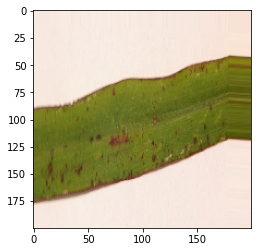

127.0.0.1 - - [26/Jun/2021 17:09:01] "POST /result.html HTTP/1.1" 200 -


Prediction: Tomato_Septoria_leaf_spot


127.0.0.1 - - [26/Jun/2021 17:09:01] "GET /static/smut-_0_2226.jpg HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 17:09:01] "GET /static/css/style.css HTTP/1.1" 404 -
127.0.0.1 - - [26/Jun/2021 17:09:04] "GET /?submit= HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 17:09:05] "GET /static/css/style.css HTTP/1.1" 404 -


static/smut-_0_2898.jpg
[3.7561127e-04 2.9631121e-02 5.5839005e-03 1.0915360e-02 7.8958814e-04
 7.6497359e-05 8.8559270e-02 1.6189214e-02 1.3811142e-02 7.8001380e-01
 2.1097107e-05 1.5727511e-04 2.5956862e-05 1.2747470e-03 5.2575391e-02]


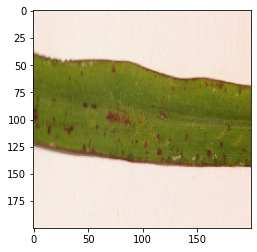

127.0.0.1 - - [26/Jun/2021 17:09:15] "POST /result.html HTTP/1.1" 200 -


Prediction: Tomato_Septoria_leaf_spot


127.0.0.1 - - [26/Jun/2021 17:09:15] "GET /static/smut-_0_2898.jpg HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 17:09:15] "GET /static/css/style.css HTTP/1.1" 404 -
127.0.0.1 - - [26/Jun/2021 17:09:18] "GET /?submit= HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 17:09:18] "GET /static/css/style.css HTTP/1.1" 404 -


static/smut-_0_4002.jpg
[2.2474794e-04 1.2655312e-01 8.4427334e-03 6.4315790e-01 8.0887426e-04
 1.6299942e-05 6.0454448e-04 1.2283642e-03 1.7437243e-01 1.7560851e-02
 2.1699188e-06 2.5893529e-05 7.9952979e-06 5.1831971e-03 2.1810863e-02]


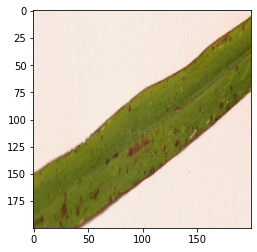

127.0.0.1 - - [26/Jun/2021 17:09:32] "POST /result.html HTTP/1.1" 200 -


Prediction: rice_leafsmut


127.0.0.1 - - [26/Jun/2021 17:09:33] "GET /static/smut-_0_4002.jpg HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 17:09:33] "GET /static/css/style.css HTTP/1.1" 404 -
127.0.0.1 - - [26/Jun/2021 17:09:44] "GET /?submit= HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 17:09:45] "GET /static/css/style.css HTTP/1.1" 404 -


static/smut-_0_4002.jpg
[2.2474794e-04 1.2655312e-01 8.4427334e-03 6.4315790e-01 8.0887426e-04
 1.6299942e-05 6.0454448e-04 1.2283642e-03 1.7437243e-01 1.7560851e-02
 2.1699188e-06 2.5893529e-05 7.9952979e-06 5.1831971e-03 2.1810863e-02]


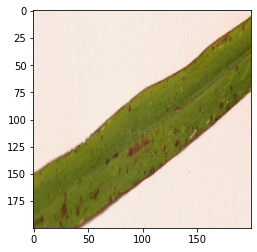

127.0.0.1 - - [26/Jun/2021 17:10:00] "POST /result.html HTTP/1.1" 200 -


Prediction: rice_leafsmut


127.0.0.1 - - [26/Jun/2021 17:10:00] "GET /static/css/style.css HTTP/1.1" 404 -
127.0.0.1 - - [26/Jun/2021 17:10:23] "GET /?submit= HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 17:10:24] "GET /static/css/style.css HTTP/1.1" 404 -


static/smut-_0_4572.jpg
[1.18548190e-03 5.56385934e-01 9.04373080e-03 6.77023605e-02
 1.80055888e-03 1.00561279e-04 7.50670535e-03 6.06497750e-02
 1.81885995e-02 2.54943848e-01 5.49676224e-05 1.17764204e-04
 1.06743748e-04 1.90665340e-03 2.03063060e-02]


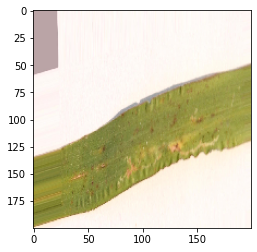

127.0.0.1 - - [26/Jun/2021 17:10:37] "POST /result.html HTTP/1.1" 200 -


Prediction: Pepper__bell___healthy


127.0.0.1 - - [26/Jun/2021 17:10:37] "GET /static/smut-_0_4572.jpg HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 17:10:38] "GET /static/css/style.css HTTP/1.1" 404 -
127.0.0.1 - - [26/Jun/2021 17:10:40] "GET /?submit= HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 17:10:40] "GET /static/css/style.css HTTP/1.1" 404 -


static/smut-_0_6763.jpg
[1.5741388e-03 5.2921753e-02 1.9363576e-03 5.1024035e-03 3.2090142e-04
 1.1405529e-04 6.1308548e-02 3.1750251e-02 1.2514995e-03 8.3178961e-01
 3.3083619e-05 9.0308153e-05 9.3791947e-05 5.1745959e-04 1.1196005e-02]


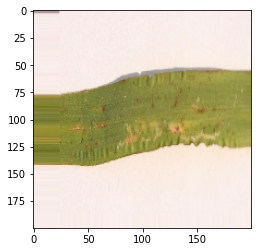

127.0.0.1 - - [26/Jun/2021 17:10:53] "POST /result.html HTTP/1.1" 200 -


Prediction: Tomato_Septoria_leaf_spot


127.0.0.1 - - [26/Jun/2021 17:10:53] "GET /static/smut-_0_6763.jpg HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 17:10:54] "GET /static/css/style.css HTTP/1.1" 404 -
127.0.0.1 - - [26/Jun/2021 17:10:56] "GET /?submit= HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 17:10:56] "GET /static/css/style.css HTTP/1.1" 404 -


static/smut-_0_7018.jpg
[5.38382519e-05 7.92842638e-03 1.48020417e-03 1.28364214e-03
 1.19736214e-04 7.72846215e-06 5.85324597e-03 4.53124335e-03
 1.03560323e-03 9.73662198e-01 1.48852632e-06 1.50253127e-05
 4.03098193e-06 2.48671509e-04 3.77508369e-03]


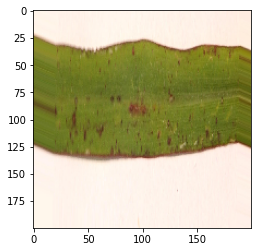

127.0.0.1 - - [26/Jun/2021 17:11:08] "POST /result.html HTTP/1.1" 200 -


Prediction: Tomato_Septoria_leaf_spot


127.0.0.1 - - [26/Jun/2021 17:11:08] "GET /static/smut-_0_7018.jpg HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 17:11:08] "GET /static/css/style.css HTTP/1.1" 404 -
127.0.0.1 - - [26/Jun/2021 17:11:11] "GET /?submit= HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 17:11:11] "GET /static/css/style.css HTTP/1.1" 404 -


static/smut-_0_7623.jpg
[9.0978883e-04 3.9675975e-01 1.4255507e-02 4.1895753e-01 1.0617957e-03
 2.6904387e-05 1.0662280e-03 3.5534783e-03 1.0225971e-01 2.9236076e-02
 3.2511016e-06 3.0344821e-05 1.7903239e-05 5.8603548e-03 2.6001362e-02]


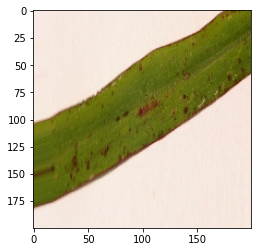

127.0.0.1 - - [26/Jun/2021 17:11:25] "POST /result.html HTTP/1.1" 200 -


Prediction: rice_leafsmut


127.0.0.1 - - [26/Jun/2021 17:11:25] "GET /static/css/style.css HTTP/1.1" 404 -
127.0.0.1 - - [26/Jun/2021 17:11:25] "GET /static/smut-_0_7623.jpg HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 17:11:34] "GET /?submit= HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 17:11:35] "GET /static/css/style.css HTTP/1.1" 404 -


static/smut-_0_8934.jpg
[1.81889554e-04 5.88684939e-02 6.05338300e-03 1.01804554e-01
 6.95653260e-04 4.83376170e-05 2.36415099e-02 9.15405974e-02
 5.17727196e-01 6.79502338e-02 6.18984923e-05 2.48842931e-04
 2.56128333e-05 2.74210013e-02 1.03730850e-01]


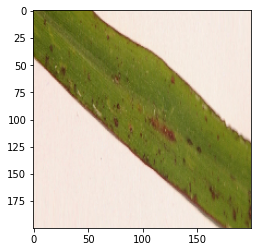

127.0.0.1 - - [26/Jun/2021 17:11:47] "POST /result.html HTTP/1.1" 200 -


Prediction: rice_brown_spot


127.0.0.1 - - [26/Jun/2021 17:11:48] "GET /static/smut-_0_8934.jpg HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 17:11:48] "GET /static/css/style.css HTTP/1.1" 404 -
127.0.0.1 - - [26/Jun/2021 17:11:58] "GET /?submit= HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 17:11:58] "GET /static/css/style.css HTTP/1.1" 404 -


static/smut-_0_9318.jpg
[3.4658902e-04 4.4817004e-02 1.1872083e-02 2.7955018e-03 8.7122532e-04
 9.4951742e-05 6.4395480e-02 4.8999600e-02 6.6037141e-03 7.9391402e-01
 6.4932437e-06 9.6378615e-05 7.8179546e-05 1.1786621e-03 2.3930142e-02]


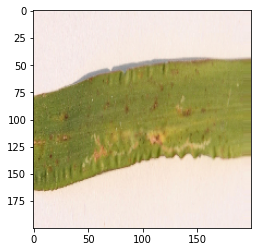

127.0.0.1 - - [26/Jun/2021 17:12:11] "POST /result.html HTTP/1.1" 200 -


Prediction: Tomato_Septoria_leaf_spot


127.0.0.1 - - [26/Jun/2021 17:12:11] "GET /static/smut-_0_9318.jpg HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 17:12:11] "GET /static/css/style.css HTTP/1.1" 404 -
127.0.0.1 - - [26/Jun/2021 17:12:13] "GET /?submit= HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 17:12:14] "GET /static/css/style.css HTTP/1.1" 404 -


static/smut-_0_9413.jpg
[5.4689206e-04 7.7170789e-02 3.4293551e-02 8.6449437e-02 1.3266433e-03
 2.3837718e-05 6.1344672e-03 1.9740855e-02 7.5503372e-02 5.8662581e-01
 5.6334570e-06 5.6657442e-05 1.5061586e-05 6.0253297e-03 1.0608161e-01]


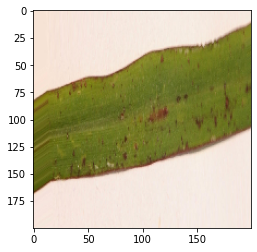

127.0.0.1 - - [26/Jun/2021 17:12:24] "POST /result.html HTTP/1.1" 200 -


Prediction: Tomato_Septoria_leaf_spot


127.0.0.1 - - [26/Jun/2021 17:12:25] "GET /static/css/style.css HTTP/1.1" 404 -
127.0.0.1 - - [26/Jun/2021 17:12:25] "GET /static/smut-_0_9413.jpg HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 17:12:28] "GET /?submit= HTTP/1.1" 200 -
127.0.0.1 - - [26/Jun/2021 17:12:28] "GET /static/css/style.css HTTP/1.1" 404 -


In [42]:
run_with_ngrok(app)
app.run()